In [1]:
try:
    from google.colab import drive
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    !pip install dill
    !mkdir -p /content/data_original && \
      cp /content/drive/MyDrive/Repo/RecoServiceTemplate/data/interactions_cp.csv /content/data_original && \
      cp /content/drive/MyDrive/Repo/RecoServiceTemplate/data/users_ohe.csv /content/data_original && \
      cp /content/drive/MyDrive/Repo/RecoServiceTemplate/data/items_ohe.csv /content/data_original && \
      cp /content/drive/MyDrive/Repo/RecoServiceTemplate/data/uid_to_user_id.dill /content/data_original && \
      cp /content/drive/MyDrive/Repo/RecoServiceTemplate/data/iid_to_item_id.dill /content/data_original

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.8 MB/s eta 0:00:00


# Homework-3. DSSM with Temporal layer

In [2]:
import math
import time
from typing import Literal, TypeAlias
import os
import pickle
import sys

from sklearn.metrics.pairwise import euclidean_distances as ED
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import dill
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from numpy.typing import NDArray
from scipy.sparse import coo_matrix, csr_matrix, vstack

# from tensorboardX import SummaryWriter
# from tensorboardX.summary import hparams

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# Set random seeds
manual_seed = 123
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [5]:
class Columns:
    """Aliases for column names."""

    Name = "item_name"
    User = "user_id"
    Item = "item_id"
    Weight = "weight"
    Date = "date"

In [6]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data loading

In [ ]:
input_datapath = "data_original"

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 200)

interactions = pd.read_csv(os.path.join(input_datapath, "interactions.csv"), header=0)
users = pd.read_csv("data_original/users.csv")
items = pd.read_csv("data_original/items.csv")

# rename columns, convert timestamp
interactions.rename(columns={"last_watch_dt": "datetime"}, inplace=True)
users.rename(columns={"user_id": Columns.User}, inplace=True)
items.rename(columns={"item_id": Columns.Item}, inplace=True)

interactions["datetime"] = pd.to_datetime(interactions["datetime"])
interactions.sort_values(by="datetime", inplace=True)

interactions["user_id"] = interactions["user_id"].astype(np.uint32)
interactions["item_id"] = interactions["item_id"].astype(np.uint16)
interactions["total_dur"] = interactions["total_dur"].astype(np.uint16)
interactions["watched_pct"] = interactions["watched_pct"].astype(np.float32)

interactions.rename(
    columns={
        "user_id": Columns.User,
        "item_id": Columns.Item,
        "datetime": Columns.Date,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)

In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5476251 entries, 1863186 to 714056
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    uint32        
 1   item_id    uint16        
 2   date       datetime64[ns]
 3   total_dur  uint16        
 4   weight     float32       
dtypes: datetime64[ns](1), float32(1), uint16(2), uint32(1)
memory usage: 146.2 MB


In [ ]:
interactions.sample(5)

,user_id,item_id,date,total_dur,weight
5321045,262486,12192,2021-08-18,267,0.0
4732213,130385,9728,2021-07-28,175,3.0
637571,742475,4880,2021-06-20,2525,18.0
1860822,531903,4976,2021-07-13,375,5.0
3914987,526561,2220,2021-07-25,5058,93.0


In [ ]:
# Check if implicit feedback contains NaNs and remove it
np.isnan(interactions.weight.values).nonzero()[0].size

828

In [ ]:
interactions.fillna(0, inplace=True)

## Preparation

### Data generation code

In [ ]:
def count_per_item(interactions: pd.DataFrame, column_name: str) -> pd.Series:
    """Get a dataframe containing size of groups formed by specific column."""
    item_groups = interactions.groupby([column_name], as_index=False).size()
    return item_groups

In [ ]:
def filter_by_limits(
    interactions: pd.DataFrame, user_lim: int, item_lim: int
) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    """Filter over the dataframe iteratively until nothing could be removed.

    Args:
        interactions: The dataframe containing interactions.
        user_lim: The mininum number of rated items that one user must have.
        item_lim: The mininum number of ratings that one item must have.

    Returns:
        Returns a tuple (interactions, user_groups, item_groups), where interactions is
            filtered dataframe, user_groups is dataframe containing number of items per
                user, item_groups is dataframe containing number of ratings per item.

    """
    while True:
        end_cycle = False
        if user_lim > 0:
            user_groups = count_per_item(interactions, Columns.User)
            n_users = len(user_groups)
            mask = interactions[Columns.User].isin(
                user_groups[user_groups["size"] >= user_lim][Columns.User].values
            )
            interactions = interactions[mask]
            # Check if smth was removed in this step
            if interactions[Columns.User].nunique() == n_users:
                end_cycle = True
        if item_lim > 0:
            item_groups = count_per_item(interactions, Columns.Item)
            n_items = len(item_groups)
            mask = interactions[Columns.Item].isin(
                item_groups[item_groups["size"] >= item_lim][Columns.Item].values
            )
            interactions = interactions[mask]

            if end_cycle and interactions[Columns.Item].nunique() == n_items:
                break

    print(f"{interactions[Columns.User].nunique()} unique users left", end="\n")
    print(f"{interactions[Columns.Item].nunique()} unique items left")

    # Sort users by ids and items by time
    interactions = interactions.sort_values([Columns.User, Columns.Date])
    user_groups, item_groups = count_per_item(
        interactions, Columns.User
    ), count_per_item(interactions, Columns.Item)
    return interactions, user_groups, item_groups

### Temporal DSSM Model code

In [10]:
class TDSSM(nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(
        self,
        ufs_dim: int,
        hidden_size: int,
        num_layers: int,
        uf1_dim: int,
        uf2_dim: int,
        if_dim: int,
        if1_dim: int,
        if2_dim: int,
        final_dim: int,
        dropout: float,
    ):
        super().__init__()

        self.user_stat_seq = nn.Sequential(
            nn.Linear(ufs_dim, uf1_dim),
            nn.BatchNorm1d(uf1_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(uf1_dim, uf2_dim),
            nn.BatchNorm1d(uf2_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(uf2_dim, final_dim),
            nn.BatchNorm1d(final_dim),
            nn.ReLU(),
        )

        self.user_temp = torch.nn.LSTM(
            input_size=if_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )

        dense_input = 2 * num_layers * hidden_size
        self.dense = torch.nn.Linear(dense_input, final_dim)

        self.item_seq = nn.Sequential(
            nn.Linear(if_dim, if1_dim),
            nn.BatchNorm1d(if1_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(if1_dim, if2_dim),
            nn.BatchNorm1d(if2_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(if2_dim, final_dim),
            nn.BatchNorm1d(final_dim),
            nn.ReLU(),
        )

        self.final_dense = nn.Linear(2 * final_dim, final_dim)

    def _create_user_vec(self, user_stat_features, user_temp_features):
        user_stat_vec = self.user_stat_seq(user_stat_features)  # to (N, final_dim)

        _, (h, c) = self.user_temp(user_temp_features)  # to (num_layers, N, H_out)
        user_temp_vec = torch.cat([h, c], dim=0).transpose(
            0, 1
        )  # to (N, 2*num_layers, H_out)
        user_temp_vec = user_temp_vec.reshape(
            len(user_temp_features), -1
        )  # to (N, 2*num_layers*H_out)
        user_temp_vec = self.dense(user_temp_vec)  # to (N, final_dim)

        user_vec = torch.cat(
            [user_stat_vec, user_temp_vec], dim=1
        )  # to (N, 2*final_dim)
        user_vec = self.final_dense(user_vec)  # to (N, final_dim)
        return user_vec

    def predict(self, user_stat_features, user_temp_features, items_features):
        # (N, final_dim)
        user_vec = self._create_user_vec(user_stat_features, user_temp_features)
        items_vec = self.item_seq(items_features)  # to (N, final_dim)
        return user_vec, items_vec

    def forward(
        self,
        user_stat_features,
        user_temp_features,
        item_pos_features,
        item_neg_features,
    ):
        # (N, final_dim)
        user_vec = self._create_user_vec(user_stat_features, user_temp_features)

        item_pos_vec = self.item_seq(item_pos_features)  # to (N, final_dim)
        item_neg_vec = self.item_seq(item_neg_features)  # to (N, final_dim)

        return user_vec, item_pos_vec, item_neg_vec

### Training Code

#### Logging

TODO:

1. Add ground-truth interactions to calculate metrics
2. Add train-test split to make Callback reasonable

In [ ]:
# class Callback:
#     """Log train and test results with help of TensorBoard.

#     Attributes:
#         writer: The summarizer of events.
#         config: The dict containing configuration params.
#         dataset: The test dataset.
#         batch_size: The size of one batch.
#         delimeter: The number of steps agter which _testing will be called.
#         k: The number of recos which are considered optimal to give.
#         loss_name: The name of loss function.

#     """

#     def __init__(
#         self,
#         writer: SummaryWriter,
#         config: dict[str, int | str | float],
#         batch_size: int,
#         delimeter: int,
#         k: int,
#     ):
#         self.step = 0
#         self.writer = writer
#         self.delimeter = delimeter
#         self.batch_size = batch_size
#         self.k = k
#         exp, ssi, sei = hparams(
#             config,
#             metric_dict={
#                 f"Losses/{self.loss_name}_train": 0,
#             },
#         )
#         self.writer.file_writer.add_summary(exp)
#         self.writer.file_writer.add_summary(ssi)
#         self.writer.file_writer.add_summary(sei)

#     def forward(self, model: Model, loss: float) -> None:
#         """Save losses and metrics values to writer."""
#         self.step += 1
#         self.writer.add_scalar(f"Losses/{self.loss_name}_train", loss, self.step)

#         if self.step % self.delimeter == 0:
#             recall, precision, mrr, map_ = self._testing(model)

#             self.writer.add_scalar(
#                 f"Losses/{self.loss_name}_test", total_loss, self.step
#             )
#             self.writer.add_scalar(f"Metrics/Recall@{self.k}", recall, self.step)
#             self.writer.add_scalar(f"Metrics/Precision@{self.k}", precision, self.step)
#             self.writer.add_scalar(f"Metrics/MRR@{self.k}", mrr, self.step)
#             self.writer.add_scalar(f"Metrics/MAP@{self.k}", map_, self.step)

#     def _testing(self, model: Model) -> tuple[float, float, float, float]:
#         recall_list: list[float] = []
#         precision_list: list[float] = []
#         mrr_list: list[float] = []
#         map_list: list[float] = []

#         test_generator = batch_generator(
#             interactions_cp,
#             users_ohe,
#             items_ohe,
#             batch_size=self.batch_size,
#             train=False,
#         )
#         for user_stat_vecs, user_temp_vecs, items_vecs in test_generator:
#             user_vecs, items_vecs = model.predict(
#                 user_stat_vecs.to(model.device),
#                 user_temp_vecs.to(model.device),
#                 items_vecs.to(model.device),
#             )
#             batch_users = user_vecs.shape[0]

#             dists = ED(user_vecs, items_vecs)
#             # Indexes of the first k recommendations
#             recos_ids = np.argpartition(-dists, k - 1, axis=1)
#             # Get recos ids in right sorted order (from high to low)
#             top_k_recs = dists[np.arange(batch_users)[:, np.newaxis], recos_ids[:, :k]]

#             # Convert to numpy
#             batch_recon_np: NDArray[np.float32] = batch_recon.to("cpu").numpy()
#             batch_valid_np: NDArray[np.float32] = batch_valid.numpy()
#             batch_input_np: NDArray[np.float32] = batch_input.numpy()

#             # Exclude known ratings that were used to build reconstruction
#             batch_recon_np[batch_input_np.nonzero()] = float("-inf")

#             # Compute metrics
#             recall = mean_recall_at_k(batch_recon_np, batch_valid_np, self.k)
#             precision = mean_precision_at_k(batch_recon_np, batch_valid_np, self.k)
#             mrr = mrr_at_k(batch_recon_np, batch_valid_np, self.k)
#             map_ = map_at_k(batch_recon_np, batch_valid_np, self.k)
#             recall_list.append(recall)
#             precision_list.append(precision)
#             mrr_list.append(mrr)
#             map_list.append(map_)

#         return (
#             total_loss,
#             sum(recall_list) / len(recall_list),
#             sum(precision_list) / len(precision_list),
#             sum(mrr_list) / len(mrr_list),
#             sum(map_list) / len(map_list),
#         )

#     def __call__(self, model: Model, loss: float):
#         return self.forward(model, loss)

#### Losses

In [ ]:
def triplet_loss(anchor, positive, negative, alpha=0.4):
    """Calculate the Triplet loss."""
    pos_dist = torch.sqrt(torch.sum(torch.square(anchor - positive), dim=1))
    neg_dist = torch.sqrt(torch.sum(torch.square(anchor - negative), dim=1))

    basic_loss = pos_dist - neg_dist + alpha
    loss = torch.max(basic_loss, torch.tensor(0.0))
    return torch.mean(loss)

In [ ]:
# Test
N, N_FACTORS = 10, 8

anchor = torch.randn(N, N_FACTORS)
positive = torch.randn(N, N_FACTORS)
negative = torch.randn(N, N_FACTORS)

print(triplet_loss(anchor, positive, negative))

tensor(0.7641)


#### Learning

In [ ]:
def train_on_batch(model, batch, optimizer) -> float:
    """Train model on only one batch of data."""
    model.train()
    optimizer.zero_grad()

    user_stat_vecs, user_temp_vecs, item_pos_vecs, item_neg_vecs = batch
    anchor, positive, negative = model(
        user_stat_vecs.to(device),
        user_temp_vecs.to(device),
        item_pos_vecs.to(device),
        item_neg_vecs.to(device),
    )

    loss = triplet_loss(anchor, positive, negative)

    loss.backward()
    optimizer.step()

    return loss.to("cpu").item()

In [ ]:
def train_epoch(
    generator,
    model,
    optimizer,
    callback,
) -> float:
    """Train model on only one epoch."""
    total_len, epoch_loss = 0, 0.0
    for batch in generator:
        batch_loss = train_on_batch(model, batch, optimizer)

        if callback:
            model.eval()
            with torch.no_grad():
                callback(model, batch_loss)

        batch_size = len(batch[0])
        epoch_loss += batch_loss * batch_size
        total_len += batch_size
    return epoch_loss / total_len

In [ ]:
def trainer(
    num_epoch: int,
    batch_size: int,
    model: TDSSM,
    optimizer_name: Literal["Adam", "SGD", "RMSprop"],
    lr: float,
    wd: float,
    callback: None,
):
    """Provide training for choosed number of epochs."""
    optimizer = getattr(torch.optim, optimizer_name)(
        model.parameters(), lr=lr, weight_decay=wd
    )

    epoch_losses = []
    iterations = tqdm(range(num_epoch), desc="epoch")
    iterations.set_postfix({"train epoch loss": np.nan})
    for _ in iterations:
        train_generator = tqdm(
            batch_generator(
                interactions_cp, users_ohe, items_ohe, batch_size=batch_size
            ),
            leave=False,
            total=len(users_ohe) // batch_size + (len(users_ohe) % batch_size > 0),
        )

        epoch_loss = train_epoch(
            train_generator,
            model,
            optimizer,
            callback,
        )

        epoch_losses.append(epoch_loss)
        iterations.set_postfix({"train epoch loss": epoch_loss})
    return epoch_losses

### Validation Code

TODO:

1. Fix metrics functions builded for AEs

#### Accuracy metrics

In [ ]:
def mean_recall_at_k(
    recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
) -> float:
    """Wrapper for recall_at_k to calculate the mean recall@K metric for batch."""
    return np.mean(recall_at_k(recon_batch, true_batch, k)).item()

In [ ]:
# def recall_at_k(
#     recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
# ) -> NDArray[np.float32]:
#     """Calculate recall@K for users in batch.

#     Recall at k is the proportion of relevant items found in the top-k recommendations.

#     Args:
#         recon_batch: The batch of recos that model built for each user.
#         true_batch: The batch thath contains only relevant items for each user.
#         k: The number of recos which are considered.

#     Returns:
#         recall_k: The batch of recall@K.

#     """
#     batch_users = recon_batch.shape[0]

#     # Indexes of the first k recommendations
#     idx = np.argpartition(-recon_batch, k - 1, axis=1)

#     # Boolean mask where True means this item is in recos at k
#     recon_batch_bool = np.zeros_like(recon_batch, dtype=bool)
#     recon_batch_bool[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

#     true_batch_bool = true_batch > 0

#     # Number of the relevant items that model recommends at k for each user in batch
#     intersection_cardinality: NDArray[np.float32] = (
#         (recon_batch_bool & true_batch_bool).sum(axis=1).astype(np.float32)
#     )

#     # Calculate the batch of Recall@K by definition
#     divider: NDArray[np.int64] = np.minimum(k, true_batch_bool.sum(axis=1))
#     recall_k = (intersection_cardinality / divider).astype(np.float32)
#     return recall_k

In [ ]:
def mean_precision_at_k(
    recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
) -> float:
    """Wrapper for precision_at_k to calculate the mean precision@K metric for batch."""
    return np.mean(precision_at_k(recon_batch, true_batch, k)).item()

In [ ]:
# def precision_at_k(
#     recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
# ) -> NDArray[np.float32]:
#     """Calculate precision@K for users in batch.

#     Precision at k is the proportion of recommended items in the top-k set
#     that are relevant.

#     Args:
#         recon_batch: The batch of recos that model built for each user.
#         true_batch: The batch thath contains only relevant items for each user.
#         k: The number of recos which are considered.

#     Returns:
#         precision_k: The batch of precision@K.

#     """
#     batch_users = recon_batch.shape[0]

#     # Indexes of the first k recommendations
#     recos_ids: NDArray[np.intp] = np.argpartition(-recon_batch, k - 1, axis=1)

#     # Boolean mask where True means this item is in recos at k
#     is_item_in_recos = np.zeros_like(recon_batch, dtype=bool)
#     is_item_in_recos[np.arange(batch_users)[:, np.newaxis], recos_ids[:, :k]] = True

#     true_batch_bool = true_batch > 0

#     # Number of the relevant items that model recommends at k for each user in batch
#     intersection_cardinality: NDArray[np.float32] = (
#         (is_item_in_recos & true_batch_bool).sum(axis=1).astype(np.float32)
#     )

#     # Calculate the batch of Precision@K by definition
#     precision_k = (intersection_cardinality / k).astype(np.float32)
#     return precision_k

#### Ranking metrics

In [ ]:
def mrr_at_k(
    recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
) -> float:
    """Wrapper for rr_at_k to calculate the mean reciprocal rank metric for batch."""
    return np.mean(rr_at_k(recon_batch, true_batch, k)).item()

In [ ]:
# def rr_at_k(
#     recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
# ) -> NDArray[np.float32]:
#     """Calculate the reciprocal ranks for users in batch.

#     The reciprocal rank of top-k recommendations is the multiplicative inverse
#     of the rank of the first relevant item occurence in this list: 1 for first place,
#     1/2 for second place, 1/3 for third place and so on.

#     Args:
#         recon_batch: The batch of recos that model built for each user.
#         true_batch: The batch thath contains only relevant items for each user.
#         k: The number of recos which are considered.

#     Returns:
#         rr: The batch of reciprocal ranks.

#     """
#     batch_users = recon_batch.shape[0]

#     # Indexes of the first k recommendations
#     recos_ids: NDArray[np.int64] = np.argpartition(-recon_batch, k - 1, axis=1)

#     # Get recos ids in right sorted order (from high to low)
#     top_k_recs = recon_batch[np.arange(batch_users)[:, np.newaxis], recos_ids[:, :k]]
#     sorted_recos_ids: NDArray[np.int64] = recos_ids[
#         np.arange(batch_users)[:, np.newaxis], np.argsort(-top_k_recs)
#     ]

#     # Boolean mask where relevant recos are True values
#     true_batch_bool = true_batch > 0
#     indicator_k = true_batch_bool[
#         np.arange(batch_users)[:, np.newaxis], sorted_recos_ids
#     ]

#     # Index of the first relevant reco for each user
#     relevant_rank: Generator[NDArray[np.int64], None, None] = (
#         np.nonzero(row == 1)[0] for row in indicator_k
#     )

#     # Calculate the batch of RR@K by definition
#     rr_list = [1.0 / (arr[0] + 1) if arr.size else 0.0 for arr in relevant_rank]
#     rr = np.array(rr_list).astype(np.float32)
#     return rr

In [ ]:
def map_at_k(
    recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
) -> float:
    """Wrapper for ap_at_k to calculate the mean average precision metric for batch."""
    return np.mean(ap_at_k(recon_batch, true_batch, k)).item()

In [ ]:
# def ap_at_k(
#     recon_batch: NDArray[np.float32], true_batch: NDArray[np.float32], k: int
# ) -> NDArray[np.float32]:
#     """Calculate the average precision for each user in batch.

#     The average precision of the top-k recommendations is the sum of precision@K
#     where the item at the kth rank is relevant divided by the total number of
#     relevant items (with adjustment to k) in the top-k recommendations.

#     Args:
#         recon_batch: The batch of recos that model built for each user.
#         true_batch: The batch thath contains only relevant items for each user.
#         k: The number of recos which are considered.

#     Returns:
#         ap: The batch of AP@K.

#     """
#     batch_users = recon_batch.shape[0]

#     true_batch_bool = true_batch > 0
#     # Indexes of the first k recommendations
#     recos_ids: NDArray[np.int64] = np.argpartition(-recon_batch, k - 1, axis=1)
#     # Get recos ids in right sorted order (from high to low)
#     top_k_recs = recon_batch[np.arange(batch_users)[:, np.newaxis], recos_ids[:, :k]]
#     sorted_recos_ids: NDArray[np.int64] = recos_ids[
#         np.arange(batch_users)[:, np.newaxis], np.argsort(-top_k_recs)
#     ]

#     # Boolean mask where relevant recos are True values
#     indicator_k = true_batch_bool[
#         np.arange(batch_users)[:, np.newaxis], sorted_recos_ids
#     ]

#     # Accumulate precisions
#     precisions = np.zeros_like(top_k_recs)
#     for running_k in range(1, k + 1):
#         # Calculate precision in a familiar way
#         is_item_in_recos = np.zeros_like(recon_batch, dtype=bool)
#         is_item_in_recos[
#             np.arange(batch_users)[:, np.newaxis], sorted_recos_ids[:, :running_k]
#         ] = True

#         intersection_cardinality: NDArray[np.float32] = (
#             (is_item_in_recos & true_batch_bool)
#             .sum(axis=1, keepdims=True)
#             .astype(np.float32)
#         )

#         precision_k = (intersection_cardinality / running_k).astype(np.float32)
#         # Update values
#         precisions[np.arange(batch_users)[:, np.newaxis], running_k - 1] = precision_k

#     # Calculate the batch of AP@K by definition
#     divider: NDArray[np.int64] = np.minimum(k, true_batch_bool.sum(axis=1))
#     ap = ((precisions * indicator_k).sum(axis=1) / divider).astype(np.float32)
#     return ap

## Pipeline

### Processing interactions data

In [ ]:
headtail(interactions)

,user_id,item_id,date,total_dur,weight
1863186,1067648,2358,2021-03-13,307,5.0
3224846,735886,9935,2021-03-13,974,15.0
2162720,993358,7417,2021-03-13,820,13.0
3551672,429759,334,2021-03-13,6380,100.0
1299803,506639,4141,2021-03-13,575,8.0
5250503,890658,1337,2021-08-22,10928,100.0
2890284,902713,14359,2021-08-22,6123,96.0
5168092,946411,13653,2021-08-22,20964,100.0
179709,779233,6646,2021-08-22,73,1.0
714056,56062,2301,2021-08-22,13,0.0


In [ ]:
interactions_cp = interactions.copy()

In [ ]:
users_cp = users.copy()
items_cp = items.copy()

In [ ]:
# Leave only long valuable interactions
interactions_cp = interactions_cp[interactions_cp[Columns.Weight] > 10]

In [ ]:
# Leave only items and users that are in all 3 dfs
common_users = set(interactions_cp[Columns.User].unique()).intersection(
    set(users_cp[Columns.User].unique())
)
common_items = set(interactions_cp[Columns.Item].unique()).intersection(
    set(items_cp[Columns.Item].unique())
)

print(len(common_users))
print(len(common_items))

interactions_cp = interactions_cp[interactions_cp[Columns.Item].isin(common_items)]
interactions_cp = interactions_cp[interactions_cp[Columns.User].isin(common_users)]

items_cp = items_cp[items_cp[Columns.Item].isin(common_items)]
users_cp = users_cp[users_cp[Columns.User].isin(common_users)]

576426
13791


In [ ]:
# Consider ACTIVE users and items that have MANY interactions
user_lim, item_lim = 10, 10

In [ ]:
# Filter and normalize data
interactions_cp, user_groups, item_groups = filter_by_limits(
    interactions_cp, user_lim, item_lim
)

maxx, minn = (
    interactions_cp[Columns.Weight].max(),
    interactions_cp[Columns.Weight].min(),
)
interactions_cp[Columns.Weight] = (interactions_cp[Columns.Weight] - minn) / (
    maxx - minn
)

74243 unique users left
5503 unique items left


In [ ]:
# Leave only items and users that are in all 3 dfs
common_users = set(interactions_cp[Columns.User].unique()).intersection(
    set(users_cp[Columns.User].unique())
)
common_items = set(interactions_cp[Columns.Item].unique()).intersection(
    set(items_cp[Columns.Item].unique())
)

print(len(common_users))
print(len(common_items))

interactions_cp = interactions_cp[interactions_cp[Columns.Item].isin(common_items)]
interactions_cp = interactions_cp[interactions_cp[Columns.User].isin(common_users)]

items_cp = items_cp[items_cp[Columns.Item].isin(common_items)]
users_cp = users_cp[users_cp[Columns.User].isin(common_users)]

74243
5503


In [ ]:
interactions_cp["uid"] = interactions_cp[Columns.User].astype("category").cat.codes
interactions_cp["iid"] = interactions_cp[Columns.Item].astype("category").cat.codes

In [ ]:
iid_to_item_id = (
    interactions_cp[["iid", Columns.Item]]
    .drop_duplicates()
    .set_index("iid")
    .to_dict()[Columns.Item]
)
item_id_to_iid = (
    interactions_cp[["iid", Columns.Item]]
    .drop_duplicates()
    .set_index(Columns.Item)
    .to_dict()["iid"]
)

uid_to_user_id = (
    interactions_cp[["uid", Columns.User]]
    .drop_duplicates()
    .set_index("uid")
    .to_dict()[Columns.User]
)
user_id_to_uid = (
    interactions_cp[["uid", Columns.User]]
    .drop_duplicates()
    .set_index(Columns.User)
    .to_dict()["uid"]
)

In [ ]:
with open(
    os.path.join(input_datapath, "iid_to_item_id.dill"),
    "wb",
) as f:
    dill.dump(iid_to_item_id, f)

In [ ]:
with open(
    os.path.join(input_datapath, "uid_to_user_id.dill"),
    "wb",
) as f:
    dill.dump(uid_to_user_id, f)

In [ ]:
interactions_cp.to_csv(os.path.join(input_datapath, "interactions_cp.csv"), index=False)

### Features Generation

#### User features

In [ ]:
users_cp.isnull().sum()

user_id       0
age         769
income      733
sex         786
kids_flg      0
dtype: int64

In [ ]:
users_cp.fillna("Unknown", inplace=True)

In [ ]:
users_cp.nunique()

user_id     74243
age             7
income          7
sex             3
kids_flg        2
dtype: int64

In [ ]:
headtail(users_cp)

,user_id,age,income,sex,kids_flg
1,962099,age_18_24,income_20_40,М,0
3,721985,age_45_54,income_20_40,Ж,0
18,155520,age_25_34,income_40_60,М,0
24,269408,age_35_44,income_20_40,Ж,1
27,384532,age_25_34,income_40_60,М,1
840121,476507,age_55_64,income_40_60,М,0
840137,486585,age_25_34,income_20_40,Ж,0
840151,534011,age_25_34,income_20_40,Ж,1
840158,788694,age_35_44,income_60_90,М,0
840163,307983,age_55_64,income_20_40,Ж,1


**One-hot encoding**

In [ ]:
users_ohe = users_cp[Columns.User]
for feature in ["sex", "age", "income", "kids_flg"]:
    feature_ohe = pd.get_dummies(users_cp[feature], prefix=feature, dtype=np.uint8)
    users_ohe = pd.concat([users_ohe, feature_ohe], axis=1)
users_ohe.head()

,user_id,sex_Unknown,sex_Ж,sex_М,age_Unknown,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_Unknown,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,kids_flg_0,kids_flg_1
1,962099,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,721985,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
18,155520,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
24,269408,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
27,384532,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
users_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74243 entries, 1 to 840163
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                74243 non-null  int64
 1   sex_Unknown            74243 non-null  uint8
 2   sex_Ж                  74243 non-null  uint8
 3   sex_М                  74243 non-null  uint8
 4   age_Unknown            74243 non-null  uint8
 5   age_age_18_24          74243 non-null  uint8
 6   age_age_25_34          74243 non-null  uint8
 7   age_age_35_44          74243 non-null  uint8
 8   age_age_45_54          74243 non-null  uint8
 9   age_age_55_64          74243 non-null  uint8
 10  age_age_65_inf         74243 non-null  uint8
 11  income_Unknown         74243 non-null  uint8
 12  income_income_0_20     74243 non-null  uint8
 13  income_income_150_inf  74243 non-null  uint8
 14  income_income_20_40    74243 non-null  uint8
 15  income_income_40_60    74243 non-null  u

In [ ]:
print(users_ohe.shape[1])

20


In [ ]:
users_ohe["uid"] = users_ohe["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe = users_ohe.set_index("uid").sort_index()

In [ ]:
users_ohe.to_csv(os.path.join(input_datapath, "users_ohe.csv"))

#### Item features

In [ ]:
headtail(items_cp)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
8,9853,film,Лабиринты прошлого,Todos lo saben,2018.0,"криминал, детективы, драмы, зарубежные, триллеры",Испания,NaN,16.0,NaN,Асгар Фархади,"Барбара Ленни, Инма Куэста, Карла Кампра, Пенелопа Крус, Рамон Бареа, Рикардо Дарин, Хавьер Бардем, Хавьер Камара, Эдуард Фернандес, Эльвира Мингес","Испанка Лаура, давно переехавшая в Буэнос-Айрес, возвращается в родной город, где встречает своего бывшего возлюбленного Пако. Он помогает Лауре, когда ее дочь попадает в руки неизвестного похитит...","Лабиринты, прошлого, 2018, Испания, семейные, проблемы, семья, отношения, отношения, мужа, жены, расследование, семейный, конфликт, загадки, тайны"
15,15076,film,Бладфест,Blood Fest,2018.0,"зарубежные, ужасы, комедии",США,NaN,18.0,NaN,Оуэн Эгертон,"Барбара Дункельман, Джейкоб Баталон, Крис Дабек, Николас Рутерфорд, Оуэн Эгертон, Робби Кей, Сейшелл Гэбриел, Тейт Донован","Фанат хорорров Дакс вместе с друзьями отправляется на фестиваль ужасов «Бладфест», где сталкивается с настоящими монстрами и убийцами, устроившими охоту на гостей. Режиссер и сценарист Оуэн Эгерто...","Бладфест, 2018, США, друзья, заговоры, страхи, убийства, убийцы, зомби, живые, мертвецы, психи, убийцы, вампиры, жестокость, кровь, отношения, отца, сына, подростковая, любовь, подростки, психолог..."
16,2904,film,Первая ведьма,The Wretched,2019.0,"зарубежные, мистика, ужасы",США,NaN,18.0,NaN,"Бретт Пирс, Дрю Т. Пирс","Ази Тесфай, Блейн Крокарелл, Габриэла Квезада Блумгарден, Гарри Бёрки, Джалайя Вашингтон, Джеймисон Джонс, Джон-Пол Ховард, Джуда Эбнер Пол, Каси Белл, Кевин Бигли, Кензи Джонс, Мэдлин Стункел, Ол...","Подросток Бен замечает пугающие перемены в поведении своих соседей. Он пытается доказать, что их дом и их души захватило древнее зло, которое охотится за детьми и стирает память о самых близких. Т...","Первая, ведьма, 2019, США, каникулы, отцы, дети, сверхъестественное, семейные, проблемы, семья, страхи, убийства, убийцы, борьба, со, злом, ведьмы, братья, сестры, дети, братская, любовь, жестокос..."
38,1622,film,Тайное окно,Secret Window,2004.0,"триллеры, детективы",США,NaN,12.0,NaN,Дэвид Кепп,"Джонни Депп, Джон Туртурро, Мария Белло, Тимоти Хаттон, Чарльз С. Даттон, Лен Кариу, Джоан Хини, Джон Данн-Хилл, Власта Врана, Мэтт Холлэнд","Писатель Морт Рейни живет в доме на берегу. Ещё недавно у него была жена и карьера писателя, сейчас с женой он встречается только для того, чтобы в очередной раз отказаться подписать документы о р...","алкоголь, измена, детектив, река Миссисипи, ревность, изоляция, паранойя, мотель, окно, страшный сон, письмо, топор, ноутбук, полиция, убийство, поджог, писатель, развод, Автор, Американский фильм..."
40,6677,film,Да здравствует Франция!,Vive la France,2013.0,комедии,Франция,NaN,16.0,NaN,"Майкл Юн, Микаэль Юн","Майкл Юн, Хосе Гарсия, Микаэль Юн, Изабель Фунаро, Эри Абиттан, Жером Коммандёр, Венсан Москато, Жан Франсуа Кэйри, Франк Гастамбид, Мусса Мааскри, Хамид Наджах","Два пастуха из несуществующей страны Табулистан отправляются во Францию, чтобы взорвать Эйфелеву башню.","Выдуманная страна, Короткие шорты, Мокрая футболка, Народные танцы, Отношения сводных братьев, Париж, Франция, Пение в машине, Втроем, Женщина топлесс, Мужчина с обнаженной грудью, Нудистский пляж..."
15956,1325,series,Старое ружьё,Staroye ruzh'ye,2014.0,"драмы, военные",Россия,NaN,16.0,NaN,К. Белевич,"Тимофей Трибунцев, Ирина Пегова, Добрыня Белевич-Оболенский, Николай Козак, Юрий Ицков, Туре Рифенштейн, Джошуа Гроте, Джулиан Мау, Фитц ван Том, Бастиан Зирих","1941 год. Петр – простой учитель в маленькой деревне. Он считает себя вне политики и уверен: если вести себя тихо и не перечить властям, тебя не тронут. Но вскоре все меняется. После ожесточенного...","вторая мировая война, человек с ружьём"
15957,15610,series,Цена любви,Tsena Lubvi,2015.0,мелодрамы,Россия,NaN,16.0,NaN,А. Хван,"Анна Невская, Юрий Батурин, Анастасия Матвеева, Ольг

In [ ]:
items_ohe = items_cp[Columns.Item]

**Genre**

In [ ]:
items_cp["genres"].isna().sum()

0

In [ ]:
# One-hot encoding
items_cp["genres"] = items_cp["genres"].str.lower().str.replace(", ", ",", regex=False)
items_ohe = pd.concat([items_ohe, items_cp["genres"].str.get_dummies(sep=",")], axis=1)
headtail(items_ohe)

,item_id,no_genre,аниме,артхаус,биография,боевики,вестерн,военные,детективы,детские,для взрослых,для детей,документальное,драмы,западные мультфильмы,зарубежные,исторические,историческое,катастрофы,комедии,концерт,короткий метр,короткометражные,криминал,медицинские,мелодрамы,мистика,музыка,музыкальные,мультсериалы,мультфильм,мультфильмы,мюзиклы,научно-популярные,по комиксам,познавательные,полнометражные,популярное,приключения,про животных,развитие,развлекательные,рекомендуем,русские,русские мультфильмы,семейное,сериалы,сказки,советские,спорт,тележурналы,телешоу,ток-шоу,триллеры,ужасы,фантастика,фильмы,фильмы hbo,фильмы-спектакли,фитнес,фэнтези,хочу всё знать,экранизации,юмор
8,9853,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15,15076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
16,2904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
38,1622,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40,6677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15956,1325,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15957,15610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15958,6443,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15959,2367,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15961,4538,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Content**

In [ ]:
items_cp["content_type"].isna().sum()

0

In [ ]:
items_cp["content_type"].unique()

array(['film', 'series'], dtype=object)

**Release year**

In [ ]:
items_cp["release_year"].isna().sum()

0

Преобразуем

In [ ]:
items_cp = items_cp.astype({"release_year": int})

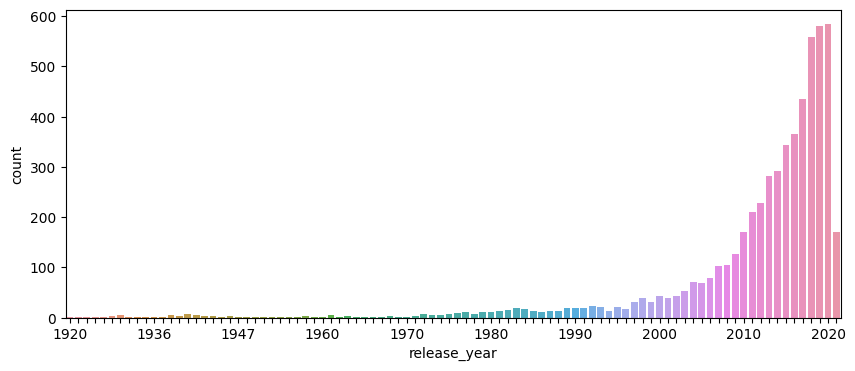

In [ ]:
plt.figure(figsize=(10, 4))
plot = sns.countplot(x=items_cp["release_year"])
# plt.tight_layout()

for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

Видим, что количество фильмов, вышедших с 1897 по ~1977, гораздо меньше, чем вышедших позже, поэтому логичнее отрезок последних лет разбить на более мелкие равные интервалы, а фильмы прошлого поместить в один более длительный

In [ ]:
year_from = 1977
step = 5
bins = [year for year in range(year_from, items_cp["release_year"].max() + step, step)]

In [ ]:
bins

[1977, 1982, 1987, 1992, 1997, 2002, 2007, 2012, 2017, 2022]

Делаем интервалы (строгое вхождение)

In [ ]:
bins_bias = [item + 1 for item in bins]

In [ ]:
pairs_strict = list(zip(bins_bias, bins[1:]))
pairs_strict

[(1978, 1982),
 (1983, 1987),
 (1988, 1992),
 (1993, 1997),
 (1998, 2002),
 (2003, 2007),
 (2008, 2012),
 (2013, 2017),
 (2018, 2022)]

In [ ]:
# Add the most first release year
bins = [items_cp["release_year"].min()] + bins
# Add interval for it
pairs_strict = [(items_cp["release_year"].min(), bins[1])] + pairs_strict
# Generate feature values
labels = [f"year_{item[0]}_{item[1]}" for item in pairs_strict]

In [ ]:
labels

['year_1920_1977',
 'year_1978_1982',
 'year_1983_1987',
 'year_1988_1992',
 'year_1993_1997',
 'year_1998_2002',
 'year_2003_2007',
 'year_2008_2012',
 'year_2013_2017',
 'year_2018_2022']

In [ ]:
year_bins = pd.cut(
    items_cp["release_year"], bins=bins, labels=labels, include_lowest=True
)

In [ ]:
items_cp["release_year"] = year_bins.astype(str)

In [ ]:
items_cp["release_year"].unique()

array(['year_2018_2022', 'year_2003_2007', 'year_2013_2017',
       'year_2008_2012', 'year_1993_1997', 'year_1998_2002',
       'year_1988_1992', 'year_1983_1987', 'year_1920_1977',
       'year_1978_1982'], dtype=object)

**Age rating**

In [ ]:
items_cp["age_rating"].isna().sum()

0

In [ ]:
items_cp["age_rating"].unique()

array([16., 18., 12.,  0.,  6., 21.])

In [ ]:
items_cp = items_cp.astype({"age_rating": np.uint8})

**For kids**

Если возраст 12+, тогда взрослый контент, иначе - детский

In [ ]:
items_cp["for_kids"].isna().sum()

5182

In [ ]:
items_cp.loc[items_cp["age_rating"] > 12, "for_kids"] = 0
items_cp.loc[items_cp["age_rating"] <= 12, "for_kids"] = 1

In [ ]:
items_cp = items_cp.astype({"for_kids": bool})

In [ ]:
headtail(items_cp)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
8,9853,film,Лабиринты прошлого,Todos lo saben,year_2018_2022,"криминал,детективы,драмы,зарубежные,триллеры",Испания,False,16,NaN,Асгар Фархади,"Барбара Ленни, Инма Куэста, Карла Кампра, Пенелопа Крус, Рамон Бареа, Рикардо Дарин, Хавьер Бардем, Хавьер Камара, Эдуард Фернандес, Эльвира Мингес","Испанка Лаура, давно переехавшая в Буэнос-Айрес, возвращается в родной город, где встречает своего бывшего возлюбленного Пако. Он помогает Лауре, когда ее дочь попадает в руки неизвестного похитит...","Лабиринты, прошлого, 2018, Испания, семейные, проблемы, семья, отношения, отношения, мужа, жены, расследование, семейный, конфликт, загадки, тайны"
15,15076,film,Бладфест,Blood Fest,year_2018_2022,"зарубежные,ужасы,комедии",США,False,18,NaN,Оуэн Эгертон,"Барбара Дункельман, Джейкоб Баталон, Крис Дабек, Николас Рутерфорд, Оуэн Эгертон, Робби Кей, Сейшелл Гэбриел, Тейт Донован","Фанат хорорров Дакс вместе с друзьями отправляется на фестиваль ужасов «Бладфест», где сталкивается с настоящими монстрами и убийцами, устроившими охоту на гостей. Режиссер и сценарист Оуэн Эгерто...","Бладфест, 2018, США, друзья, заговоры, страхи, убийства, убийцы, зомби, живые, мертвецы, психи, убийцы, вампиры, жестокость, кровь, отношения, отца, сына, подростковая, любовь, подростки, психолог..."
16,2904,film,Первая ведьма,The Wretched,year_2018_2022,"зарубежные,мистика,ужасы",США,False,18,NaN,"Бретт Пирс, Дрю Т. Пирс","Ази Тесфай, Блейн Крокарелл, Габриэла Квезада Блумгарден, Гарри Бёрки, Джалайя Вашингтон, Джеймисон Джонс, Джон-Пол Ховард, Джуда Эбнер Пол, Каси Белл, Кевин Бигли, Кензи Джонс, Мэдлин Стункел, Ол...","Подросток Бен замечает пугающие перемены в поведении своих соседей. Он пытается доказать, что их дом и их души захватило древнее зло, которое охотится за детьми и стирает память о самых близких. Т...","Первая, ведьма, 2019, США, каникулы, отцы, дети, сверхъестественное, семейные, проблемы, семья, страхи, убийства, убийцы, борьба, со, злом, ведьмы, братья, сестры, дети, братская, любовь, жестокос..."
38,1622,film,Тайное окно,Secret Window,year_2003_2007,"триллеры,детективы",США,True,12,NaN,Дэвид Кепп,"Джонни Депп, Джон Туртурро, Мария Белло, Тимоти Хаттон, Чарльз С. Даттон, Лен Кариу, Джоан Хини, Джон Данн-Хилл, Власта Врана, Мэтт Холлэнд","Писатель Морт Рейни живет в доме на берегу. Ещё недавно у него была жена и карьера писателя, сейчас с женой он встречается только для того, чтобы в очередной раз отказаться подписать документы о р...","алкоголь, измена, детектив, река Миссисипи, ревность, изоляция, паранойя, мотель, окно, страшный сон, письмо, топор, ноутбук, полиция, убийство, поджог, писатель, развод, Автор, Американский фильм..."
40,6677,film,Да здравствует Франция!,Vive la France,year_2013_2017,комедии,Франция,False,16,NaN,"Майкл Юн, Микаэль Юн","Майкл Юн, Хосе Гарсия, Микаэль Юн, Изабель Фунаро, Эри Абиттан, Жером Коммандёр, Венсан Москато, Жан Франсуа Кэйри, Франк Гастамбид, Мусса Мааскри, Хамид Наджах","Два пастуха из несуществующей страны Табулистан отправляются во Францию, чтобы взорвать Эйфелеву башню.","Выдуманная страна, Короткие шорты, Мокрая футболка, Народные танцы, Отношения сводных братьев, Париж, Франция, Пение в машине, Втроем, Женщина топлесс, Мужчина с обнаженной грудью, Нудистский пляж..."
15956,1325,series,Старое ружьё,Staroye ruzh'ye,year_2013_2017,"драмы,военные",Россия,False,16,NaN,К. Белевич,"Тимофей Трибунцев, Ирина Пегова, Добрыня Белевич-Оболенский, Николай Козак, Юрий Ицков, Туре Рифенштейн, Джошуа Гроте, Джулиан Мау, Фитц ван Том, Бастиан Зирих","1941 год. Петр – простой учитель в маленькой деревне. Он считает себя вне политики и уверен: если вести себя тихо и не перечить властям, тебя не тронут. Но вскоре все меняется. После ожесточенного...","вторая мировая война, человек с ружьём"
15957,15610,series,Цена любви,Tsena Lubvi,year_2013_2017,мелодрамы,Россия,False,16,NaN,А. Хван,"Анна Не

**Studios**

In [ ]:
items_cp["studios"].unique()

array([nan, 'BBC', 'Paramount', 'Universal', 'Sony Pictures', 'Sky',
       'CBS', 'Sky, Fremantle', 'Starz', 'HBO', 'Warner Bros',
       'Fremantle', 'Ленфильм, рентв', 'Showtime', 'Endemol', 'Cinemax',
       'Sony Pictures Television', 'Ленфильм', 'CBS All Access',
       'Sony Pictures, рентв', 'Amediateka', 'Рок фильм', 'HBO Max',
       'Fox', 'Warner Bros. Television', 'Legendary', 'Channel 4',
       'New Regency Productions'], dtype=object)

In [ ]:
items_cp["studios"].fillna("Unknown", inplace=True)

In [ ]:
# One-hot encoding
items_cp["studios"] = items_cp["studios"].str.replace(", ", ",", regex=False)
items_ohe = pd.concat([items_ohe, items_cp["studios"].str.get_dummies(sep=",")], axis=1)
headtail(items_ohe)

,item_id,no_genre,аниме,артхаус,биография,боевики,вестерн,военные,детективы,детские,для взрослых,для детей,документальное,драмы,западные мультфильмы,зарубежные,исторические,историческое,катастрофы,комедии,концерт,короткий метр,короткометражные,криминал,медицинские,мелодрамы,мистика,музыка,музыкальные,мультсериалы,мультфильм,мультфильмы,мюзиклы,научно-популярные,по комиксам,познавательные,полнометражные,популярное,приключения,про животных,развитие,развлекательные,рекомендуем,русские,русские мультфильмы,семейное,сериалы,сказки,советские,спорт,тележурналы,телешоу,ток-шоу,триллеры,ужасы,фантастика,фильмы,фильмы hbo,фильмы-спектакли,фитнес,фэнтези,хочу всё знать,экранизации,юмор,Amediateka,BBC,CBS,CBS All Access,Channel 4,Cinemax,Endemol,Fox,Fremantle,HBO,HBO Max,Legendary,New Regency Productions,Paramount,Showtime,Sky,Sony Pictures,Sony Pictures Television,Starz,Universal,Unknown,Warner Bros,Warner Bros. Television,Ленфильм,Рок фильм,рентв
8,9853,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15,15076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16,2904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
38,1622,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
40,6677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15956,1325,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15957,15610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15958,6443,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15959,2367,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15961,4538,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


**Сountries**

In [ ]:
items_cp[items_cp["countries"].isna()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
9505,13864,film,Бруно против Тайсона,Bruno vs. Tyson,year_2018_2022,спорт,NaN,False,18,Unknown,NaN,NaN,"Документальный проект о двух великих боксерах — Майке Тайсоне и Фрэнке Бруно. Фильм покажет взлеты и падения спортсменов и, конечно же, расскажет о их знаменитом противостоянии. «Бруно против Тайс...","Бруно, против, Тайсона, 2021"


Вручную доопределим, так как это известно

In [ ]:
items_cp.at[9505, "countries"] = "США"

In [ ]:
# One-hot encoding
items_cp["countries"] = items_cp["countries"].str.replace(", ", ",", regex=False)
items_ohe = pd.concat(
    [items_ohe, items_cp["countries"].str.get_dummies(sep=",")], axis=1
)
headtail(items_ohe)

,item_id,no_genre,аниме,артхаус,биография,боевики,вестерн,военные,детективы,детские,для взрослых,для детей,документальное,драмы,западные мультфильмы,зарубежные,исторические,историческое,катастрофы,комедии,концерт,короткий метр,короткометражные,криминал,медицинские,мелодрамы,мистика,музыка,музыкальные,мультсериалы,мультфильм,мультфильмы,мюзиклы,научно-популярные,по комиксам,познавательные,полнометражные,популярное,приключения,про животных,развитие,развлекательные,рекомендуем,русские,русские мультфильмы,семейное,сериалы,сказки,советские,спорт,тележурналы,телешоу,ток-шоу,триллеры,ужасы,фантастика,фильмы,фильмы hbo,фильмы-спектакли,фитнес,фэнтези,хочу всё знать,экранизации,юмор,Amediateka,BBC,CBS,CBS All Access,Channel 4,Cinemax,Endemol,Fox,Fremantle,HBO,HBO Max,Legendary,New Regency Productions,Paramount,Showtime,Sky,Sony Pictures,Sony Pictures Television,Starz,Universal,Unknown,Warner Bros,Warner Bros. Television,Ленфильм,Рок фильм,рентв,Австралия,Австрия,Алжир,Аргентина,Армения,Беларусь,Бельгия,Болгария,Бразилия,Великобритания,Венгрия,Венесуэла,Германия,Гонконг,Греция,Грузия,Дания,Замбия,Израиль,Индия,Индонезия,Иордания,Иран,Ирландия,Исландия,Испания,Италия,Казахстан,Камбоджа,Канада,Кения,Кипр,Китай,Колумбия,Куба,Латвия,Ливан,Литва,Люксембург,Маврикий,Малайзия,Мальта,Марокко,Мексика,Молдова,Нидерланды,Новая Зеландия,Норвегия,ОАЭ,Перу,Польша,Португалия,Пуэрто-Рико,Республика Корея,Россия,Румыния,СССР,США,Сенегал,Сербия,Сингапур,Словакия,Словения,Таиланд,Тайвань,Тунис,Турция,Украина,Уругвай,Филиппины,Финляндия,Франция,Хорватия,Чехия,Чили,Швейцария,Швеция,Эквадор,Эстония,ЮАР,Япония
8,9853,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,15076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,2904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38,1622,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,6677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
15956,1325,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15957,15610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

**Directors**

In [ ]:
items_cp["directors"].isna().sum()

127

In [ ]:
items_cp["directors"].fillna("Unknown", inplace=True)

In [ ]:
items_cp["directors"].nunique()

3789

В целях экономии памяти отбросим режиссеров, у которых меньше 2 фильмов, поместив их в категорию "Unknown"

In [ ]:
dirs = items_cp.groupby("directors").size() >= 2
valid_dirs = set(dirs[dirs].index)

In [ ]:
items_cp.loc[~items_cp["directors"].isin(valid_dirs), "directors"] = "Unknown"

In [ ]:
# One-hot encoding
items_cp["directors"] = items_cp["directors"].str.replace(", ", ",", regex=False)
items_ohe = pd.concat(
    [items_ohe, items_cp["directors"].str.get_dummies(sep=",")], axis=1
)
headtail(items_ohe)

,item_id,no_genre,аниме,артхаус,биография,боевики,вестерн,военные,детективы,детские,для взрослых,для детей,документальное,драмы,западные мультфильмы,зарубежные,исторические,историческое,катастрофы,комедии,концерт,короткий метр,короткометражные,криминал,медицинские,мелодрамы,мистика,музыка,музыкальные,мультсериалы,мультфильм,мультфильмы,мюзиклы,научно-популярные,по комиксам,познавательные,полнометражные,популярное,приключения,про животных,развитие,развлекательные,рекомендуем,русские,русские мультфильмы,семейное,сериалы,сказки,советские,спорт,тележурналы,телешоу,ток-шоу,триллеры,ужасы,фантастика,фильмы,фильмы hbo,фильмы-спектакли,фитнес,фэнтези,хочу всё знать,экранизации,юмор,Amediateka,BBC,CBS,CBS All Access,Channel 4,Cinemax,Endemol,Fox,Fremantle,HBO,HBO Max,Legendary,New Regency Productions,Paramount,Showtime,Sky,Sony Pictures,Sony Pictures Television,Starz,Universal,Unknown,Warner Bros,Warner Bros. Television,Ленфильм,Рок фильм,рентв,Австралия,Австрия,Алжир,Аргентина,Армения,Беларусь,Бельгия,Болгария,Бразилия,Великобритания,Венгрия,Венесуэла,Германия,Гонконг,Греция,Грузия,Дания,Замбия,Израиль,Индия,Индонезия,Иордания,Иран,Ирландия,Исландия,Испания,Италия,Казахстан,Камбоджа,Канада,Кения,Кипр,Китай,Колумбия,Куба,Латвия,Ливан,Литва,Люксембург,Маврикий,Малайзия,Мальта,Марокко,Мексика,Молдова,Нидерланды,Новая Зеландия,Норвегия,ОАЭ,Перу,Польша,Португалия,Пуэрто-Рико,Республика Корея,Россия,Румыния,СССР,США,Сенегал,Сербия,Сингапур,Словакия,Словения,Таиланд,Тайвань,Тунис,Турция,Украина,Уругвай,Филиппины,Финляндия,Франция,Хорватия,Чехия,Чили,Швейцария,Швеция,Эквадор,Эстония,ЮАР,Япония,Unknown,Ён Сан-хо,А. Рогожкин,А.Грабарь,Аарон Мурхед,Аарон Соркин,Авдотья Смирнова,Адам Вингард,Адам МакДональд,Адам Робител,Адиль Эль Арби,Азазель Джейкобс,Азиф Кападиа,Аида Зябликова,Айвен Райтман,Акан Сатаев,Акира Куросава,Алан Тейлор,Алекс Пройас,Алекс Стадерманн,Алекс де ла Иглесиа,Александр Ажа,Александр Баранов,Александр Баршак,Александр Бланк,Александр Богуславский,Александр Велединский,Александр Войтинский,Александр Даруга,Александр Кананович,Александр Карпиловский,Александр Касаткин,Александр Котт,Александр Муратов,Александр Прошкин,Александр Рогожкин,Александр Роу,Александр Татарский,Александр Хван,Александра Стреляная,Алексей А. Петрухин,Алексей Балабанов,Алексей Козлов,Алексей Котеночкин,Алексей Мизгирёв,Алексей Нужный,Алексей Сидоров,Алексей Учитель,Алексей Цицилин,Алексей Чупов,Ален Дерошер,Ален Ниязбеков,Алена Званцова,Алехандро Аменабар,Альбер Дюпонтель,Альфред Хичкок,Анатолий Матешко,Анджали Кара,Анджей Бартковяк,Анджей Гавриш,Андре Овредал,Андрей Богатырев,Андрей Волгин,Андрей Грачев,Андрей Звягинцев,Андрей Прошкин,Андрей Яковлев,Аниш Чаганти,Анн Фонтен,Анна Матисон,Анна Меликян,Антон Бильжо,Антон Борматов,Антон Корбейн,Антон Маслов,Антон Мегердичев,Антон Федотов,Антонио Падован,Антуан Фукуа,Ари Астер,Арман Геворгян,Артем Аксененко,Артур Днепровский,Артур Меркулов,Артём Аксёненко,Аск Хассельбальх,Бад Фокс,Баз Лурман,Бальтасар Кормакур,Барри Зонненфельд,Барри Левинсон,Бен Стассен,Бен Стиллер,Бен Уитли,Бенджамин Моннеро-Дюмейн,Бернар Геррини,Бернард Роуз,Берт Пот,Бетти Томас,Билал Фалла,Билл Кондон,Билле Аугуст,Билле Вудрафф,Бобби Фаррелли,Бора Дагтекин,Борис Дуров,Брайан А. Миллер,Брайан Де Пальма,Брайан Левант,Брайан Сингер,Брайан Смит,Брайан Тейлор,Бретт Рэтнер,Бруно Маттеи,Брэд Бёрд,Брэд Фурман,Брэйди Корбет,Бхарат Наллури,В.Фокин,Вадим Дубровицкий,Вадим Зобин,Вадим Перельман,Вадим Шмелев,Валентино Пиконе,Валерий Ибрагимов,Валерий Тодоровский,Валерий Усков,Валерия Гай Германика,Вера Глаголева,Виктор Гарсия,Виктор Сальва,Виктор Шамиров,Винсент Кестелут,Винченцо Натали,Влад Фурман,Владимир Алеников,Владимир Бортко,Владимир Грамматиков,Владимир Котт,Владимир Краснопольский,Владимир Меньшов,Владимир Торопчин,Владимир Фатьянов,Вольфганг Гроос,Вольфганг Райтерман,Вонг Кар-Вай,Вуайерист,Вуди Аллен,Вячеслав Никифоров,Габриэле Муччино,Газзман,Газман,Гай Ричи,Гари Виник,Гари Труздейл,Гарри Бардин,Гас Ван Сент,Гаспар Ноэ,Геннадий Байсак,Геннди

**One-hot encoding for the rest**

In [ ]:
for feature in ["content_type", "release_year", "for_kids", "age_rating"]:
    feature_ohe = pd.get_dummies(items_cp[feature], prefix=feature, dtype=np.uint8)
    items_ohe = pd.concat([items_ohe, feature_ohe], axis=1)

In [ ]:
items_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5503 entries, 8 to 15961
Columns: 1013 entries, item_id to age_rating_21
dtypes: int64(993), uint8(20)
memory usage: 42.0 MB


In [ ]:
print(items_ohe.shape[1])

1013


In [ ]:
items_ohe["iid"] = items_ohe["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe = items_ohe.set_index("iid").sort_index()

In [ ]:
items_ohe.to_csv(os.path.join(input_datapath, "items_ohe.csv"))

### Load processed data

In [13]:
input_datapath = "data_original"

interactions_cp = pd.read_csv(os.path.join(input_datapath, "interactions_cp.csv"))
interactions_cp[Columns.User] = interactions_cp[Columns.User].astype(np.uint32)
interactions_cp[Columns.Item] = interactions_cp[Columns.Item].astype(np.uint16)
interactions_cp["uid"] = interactions_cp["uid"].astype(np.uint32)
interactions_cp["iid"] = interactions_cp["iid"].astype(np.uint16)
interactions_cp[Columns.Date] = pd.to_datetime(interactions_cp[Columns.Date])

users_ohe = pd.read_csv(os.path.join(input_datapath, "users_ohe.csv"), index_col="uid")
items_ohe = pd.read_csv(os.path.join(input_datapath, "items_ohe.csv"), index_col="iid")

In [14]:
with open(
    os.path.join(input_datapath, "uid_to_user_id.dill"),
    "rb",
) as f:
    uid_to_user_id = dill.load(f)

In [15]:
with open(
    os.path.join(input_datapath, "iid_to_item_id.dill"),
    "rb",
) as f:
    iid_to_item_id = dill.load(f)

### Data Generator

In [16]:
def batch_generator(
    interactions: pd.DataFrame,
    users_ohe: pd.DataFrame,
    items_ohe: pd.DataFrame,
    batch_size: int = 1024,
    train: bool = True,
):
    n_samples = len(users_ohe)
    unq_iid = np.unique(interactions["iid"])

    PAD = len(items_ohe)
    item_features = items_ohe.drop("item_id", axis=1).values
    # Add PAD vector to item features (just zeroes vector)
    item_features_mapping = np.append(
        item_features,
        np.zeros((1, item_features.shape[1])),
        axis=0,
    )

    # Number of batches
    n_batches = n_samples // batch_size
    if n_samples % batch_size != 0:
        n_batches += 1

    # Shuffle uids if the train stage
    uid = np.arange(len(users_ohe))
    if train:
        np.random.shuffle(uid)

    for k in range(n_batches):
        # Point out current size
        this_batch_size = batch_size

        # last batch is cutted out
        if k == n_batches - 1:
            if n_samples % batch_size > 0:
                this_batch_size = n_samples % batch_size

        uid_subset = uid[k * batch_size : k * batch_size + this_batch_size]

        ## USERS VECTORS
        # Get user static features vectors for this subset uids
        user_stat_vecs_df = users_ohe.loc[users_ohe.index.isin(uid_subset)]
        user_stat_vecs_np = user_stat_vecs_df.drop(Columns.User, axis=1).values
        user_stat_vecs = torch.FloatTensor(user_stat_vecs_np)

        # Add all watched items by right time order for this subset uids
        items = []
        for _, user_group in interactions.loc[
            interactions["uid"].isin(uid_subset), :
        ].groupby("uid"):
            items.append(user_group["iid"].tolist())

        # Finding the highest number of the items among users in current batch (HNIB)
        batch_lengths = [len(items_per_user) for items_per_user in items]
        hnib = max(batch_lengths)

        # Turning batch into nd.array with size batch_size * HNIB
        items_padded = np.ones(shape=[this_batch_size, hnib], dtype=int) * PAD

        for i in range(this_batch_size):
            items_padded[i, : len(items[i])] = items[i]

        # Get user temporal features vectors for this subset uids
        user_temp_vecs = item_features_mapping[items_padded]
        user_temp_vecs = torch.FloatTensor(user_temp_vecs)

        ## ITEMS VECTORS
        if train:
            # Pick one positive item for each user
            iid_pos_df = (
                interactions.loc[interactions["uid"].isin(uid_subset), :]
                .groupby("uid")
                .sample(1)[["uid", "iid"]]
                .set_index("iid")
            )
            # Get positive item features vectors for this subset uids
            iid_pos_df = iid_pos_df.join(items_ohe).set_index("uid").sort_index()
            iid_pos_np = iid_pos_df.drop(Columns.Item, axis=1).values
            item_pos_vecs = torch.FloatTensor(iid_pos_np)

            # Pick one negative item for each user
            # (can be positives here, but probability is very low)
            iid_neg = np.random.choice(unq_iid, size=this_batch_size)
            # Get negative item features vectors for this subset uids
            iid_neg_df = (
                pd.DataFrame(
                    iid_neg, index=pd.Series(uid_subset, name="uid"), columns=["iid"]
                )
                .reset_index()
                .set_index("iid")
            )
            iid_neg_df = iid_neg_df.join(items_ohe).set_index("uid").sort_index()
            iid_neg_np = iid_neg_df.drop(Columns.Item, axis=1).values
            item_neg_vecs = torch.FloatTensor(iid_neg_np)

            yield user_stat_vecs, user_temp_vecs, item_pos_vecs, item_neg_vecs
        else:
            items_features = items_ohe.drop([Columns.Item], axis=1).values
            items_vecs = torch.FloatTensor(items_features)
            yield user_stat_vecs, user_temp_vecs, items_vecs

In [17]:
train_generator = batch_generator(interactions_cp, users_ohe, items_ohe, batch_size=10)
user_stat_vecs, user_temp_vecs, item_pos_vecs, item_neg_vecs = next(train_generator)

In [18]:
print("User static features:", user_stat_vecs.size())
print("_" * 100)
print("User temporal features:", user_temp_vecs.size())
print("_" * 100)
print("Items positive vectors:", item_pos_vecs.size())
print("_" * 100)
print("Items negative vectors:", item_neg_vecs.size())

User static features: torch.Size([10, 19])
____________________________________________________________________________________________________
User temporal features: torch.Size([10, 44, 1012])
____________________________________________________________________________________________________
Items positive vectors: torch.Size([10, 1012])
____________________________________________________________________________________________________
Items negative vectors: torch.Size([10, 1012])


In [19]:
test_generator = batch_generator(
    interactions_cp, users_ohe, items_ohe, batch_size=10, train=False
)
user_stat_vecs, user_temp_vecs, items_vecs = next(test_generator)

In [20]:
print("User static features:", user_stat_vecs.size())
print("_" * 100)
print("User temporal features:", user_temp_vecs.size())
print("_" * 100)
print("Items  vectors:", items_vecs.size())

User static features: torch.Size([10, 19])
____________________________________________________________________________________________________
User temporal features: torch.Size([10, 45, 1012])
____________________________________________________________________________________________________
Items  vectors: torch.Size([5503, 1012])


### Model initialization

In [21]:
config = dict()

config["ufs_dim"] = users_ohe.drop(Columns.User, axis=1).values.shape[1]
config["uf1_dim"] = 64
config["uf2_dim"] = 64
config["hidden_size"] = 64
config["num_layers"] = 3
config["if_dim"] = items_ohe.drop(Columns.Item, axis=1).values.shape[1]
config["if1_dim"] = 512
config["if2_dim"] = 256
config["final_dim"] = 128
config["dropout"] = 0.3

In [ ]:
model = TDSSM(**config)

In [ ]:
# Model test
# Train
user_vec, item_pos_vec, item_neg_vec = model(
    user_stat_vecs, user_temp_vecs, item_pos_vecs, item_neg_vecs
)

print("Users vectors:", user_vec.size())
print("_" * 100)
print("Items positive vectors per user:", item_pos_vec.size())
print("_" * 100)
print("Items negative vectors per user:", item_neg_vec.size())

print("_" * 100)
print("_" * 100)

# Inference
user_vec, items_vec = model.predict(user_stat_vecs, user_temp_vecs, items_vecs)
print("Users vectors:", user_vec.size())
print("_" * 100)
print("Items vectors:", items_vecs.size())
print("_" * 100)

Users vectors: torch.Size([10, 128])
____________________________________________________________________________________________________
Items positive vectors per user: torch.Size([10, 128])
____________________________________________________________________________________________________
Items negative vectors per user: torch.Size([10, 128])
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Users vectors: torch.Size([10, 128])
____________________________________________________________________________________________________
Items vectors: torch.Size([5503, 1012])
____________________________________________________________________________________________________


### Training

In [ ]:
# Set other params of training
num_epoch: int = 5
batch_size: int = 512
model: TDSSM = TDSSM(**config)
optimizer_name: Literal["Adam", "SGD", "RMSprop"] = "Adam"
lr: float = 0.001
wd: float = 0.01  # Optimizer weight decay
callback: None = None  # Callback function or absense of it

In [ ]:
_ = model.to(device)

In [ ]:
print("Training starts.")
start = time.time()
epoch_losses = trainer(
    num_epoch,
    batch_size,
    model,
    optimizer_name,
    lr,
    wd,
    callback,
)
end = time.time()
print("Training ends.")

Training starts.


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

Training ends.


Text(0, 0.5, 'Loss')

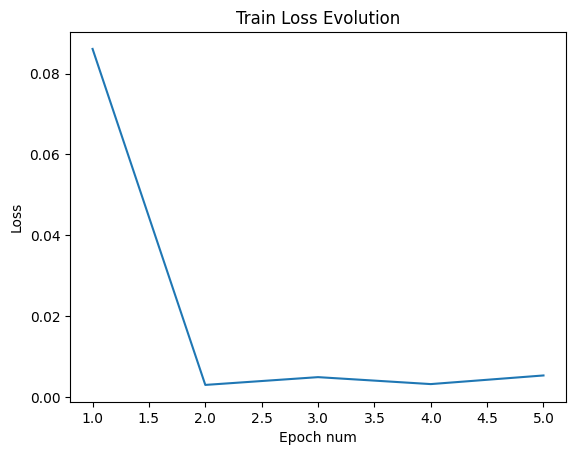

In [ ]:
plt.plot(np.arange(1, num_epoch + 1), epoch_losses)
plt.title("Train Loss Evolution")
plt.xlabel("Epoch num")
plt.ylabel("Loss")

In [8]:
output_modelpath = "model"
if not os.path.exists(output_modelpath):
    os.makedirs(output_modelpath)

In [ ]:
output_modelpath = os.path.join(output_modelpath, "weights.pt")
with open(output_modelpath, "wb") as fp:
    torch.save(model.state_dict(), fp)

### Predictions

In [22]:
model: TDSSM = TDSSM(**config)

input_modelpath = "model"
with open(os.path.join(input_modelpath, "weights.pt"), "rb") as fp:
    state_dict = torch.load(fp, map_location=torch.device("cpu"))
model.load_state_dict(state_dict)
model.to(device)
model.eval()

TDSSM(
  (user_stat_seq): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (user_temp): LSTM(1012, 64, num_layers=3, batch_first=True, dropout=0.3)
  (dense): Linear(in_features=384, out_features=128, bias=True)
  (item_seq): Sequential(
    (0): Linear(in_features=1012, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): 

In [24]:
batch_size = 512
k = 10

In [25]:
test_generator = batch_generator(
    interactions_cp,
    users_ohe,
    items_ohe,
    batch_size=batch_size,
    train=False,
)

hot_recs = []
for user_stat_vecs, user_temp_vecs, items_vecs in test_generator:
    user_vec, items_vec = model.predict(
        user_stat_vecs.to(model.device),
        user_temp_vecs.to(model.device),
        items_vecs.to(model.device),
    )
    batch_users = user_vec.shape[0]

    dists = ED(
        user_vec.detach().to("cpu").numpy(), items_vec.detach().to("cpu").numpy()
    )
    # Indexes of the first k recommendations
    recos_ids = np.argpartition(-dists, k, axis=1)
    recos_top_k = recos_ids[:, :k]
    # Go back to the external item ids
    recos_top_k = np.vectorize(iid_to_item_id.get)(recos_top_k)
    hot_recs.append(recos_top_k)

hot_recs = np.vstack(hot_recs)
user_recs_external = dict(enumerate(hot_recs, 0))
# Go back to the external item ids
user_recs = {uid_to_user_id[key]: value.tolist() for key, value in user_recs_external.items()}

Сохраним данные (оффлайн-модель)


In [33]:
# Save recs for hot users as dict
input_dimspath = os.path.join(input_datapath, "tdssm_user_recs.dill")
with open(input_dimspath, "wb") as fp:
    dill.dump(user_recs, fp)